# Задача 3. Детектирование токсичных комментариев

Вам будет предоставлен корпус размеченных (0 - не токсик, 1 - токсик) текстов, где тексты представляют собой комментарии. Необходимо выполнить их семантический анализ и классифицировать на позитивные и негативные (токсичные).

Задачу можно решить как минимум двумя способами: классической текстовой моделью TF-IDF или с помощью нейронок типа BERT трансформера (суть таких нейронок в общем схожа - они делают эмбендинги слов - верктоные представления)

В качестве метрики используйте f1-меру

полезные источники:

https://habr.com/ru/companies/otus/articles/755772/

https://habr.com/ru/articles/446530/

https://habr.com/ru/companies/otus/articles/702838/


# Импортируем необходимые библиотеки 

Импорт основных библиотек 

In [123]:
import os
import re

import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

warnings.filterwarnings('ignore')

Импорт спец. библиотек

In [124]:
import nltk
from tqdm import tqdm
import tensorflow as tf
from nltk.corpus import wordnet
from pymystem3 import Mystem
from catboost import CatBoostClassifier
import tqdm
from sentence_transformers import SentenceTransformer

импорт элементов библиотеки Scikit-Learn

In [125]:
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

## Подготовка данных 

откроем и изучим файл

In [126]:
df = pd.read_csv('toxic_comments.csv',names=['text','toxic'],skiprows=[0])

In [127]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Проверим типы данных

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [129]:
df.describe()

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Итог
Датасет содержит почти 160 тыс. комментариев.

## Тип данных
Тип данных соответствует содержанию в колонка.

## Пропуски и дубликаты
Пропуски и дубликаты - отсутствуют.


## Рассмотрим распределение позитивных и негативных коментрариев

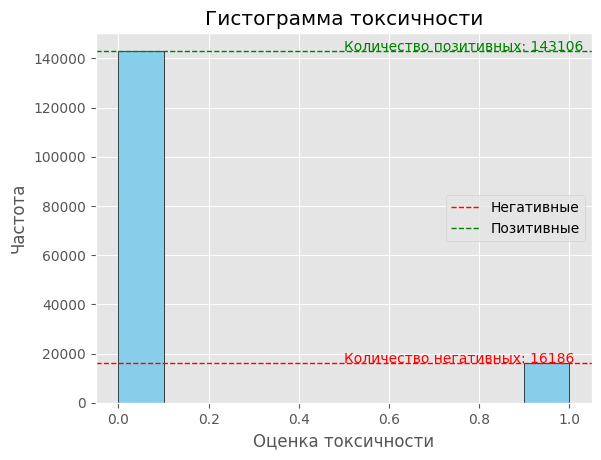

In [130]:
# Используем стиль ggplot для более привлекательного внешнего вида
plt.style.use('ggplot')

# Построение гистограммы
plt.hist(df['toxic'], bins=10, color='skyblue', edgecolor='black')

# Добавление заголовка и меток осей на русском языке
plt.title('Гистограмма токсичности')
plt.xlabel('Оценка токсичности')
plt.ylabel('Частота')

# Добавление уровней для отметки количества токсичных и нетоксичных комментариев
toxic_count = df[df['toxic'] == 1]['toxic'].count()
non_toxic_count = df[df['toxic'] == 0]['toxic'].count()

plt.axhline(toxic_count, color='red', linestyle='--', linewidth=1, label='Негативные')
plt.axhline(non_toxic_count, color='green', linestyle='--', linewidth=1, label='Позитивные')

# Добавление текста с количеством над каждой линией
plt.text(0.5, toxic_count + 10, f'Количество негативных: {toxic_count}', color='red', fontsize=10)
plt.text(0.5, non_toxic_count + 10, f'Количество позитивных: {non_toxic_count}', color='green', fontsize=10)

# Добавление легенды
plt.legend()

# Добавление сетки для лучшей читаемости
plt.grid(True)

# Отображение гистограммы
plt.show()


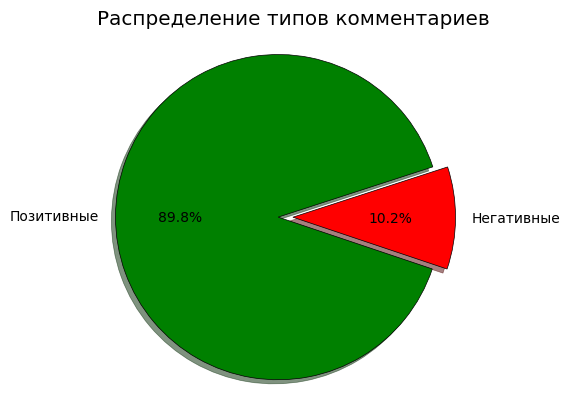

In [131]:
# Используем стиль ggplot для более привлекательного внешнего вида
plt.style.use('ggplot')

# Распределение токсичности комментариев на круговой диаграмме
plt.pie(df['toxic'].value_counts(),
        labels=['Позитивные', 'Негативные'],
        autopct='%1.1f%%',
        startangle=18,
        explode=(0.1, 0),  # добавляем небольшое расстояние между сегментами
        shadow=True,
        colors=['green', 'red'],  # цвета для позитивных и негативных комментариев соответственно
        wedgeprops={'edgecolor': 'black'},  # добавляем черную границу для каждого сегмента
        radius=1.10)
plt.title('Распределение типов комментариев')

# Отображение круговой диаграммы
plt.show()

## Итог 

Присутствует дисбаланс классов: позитивных комментариев больше в 9 раз.


## Длина комментариев

In [132]:
df['comment_length'] = df['text'].str.len()

In [133]:
df['comment_length'].describe()

count    159292.000000
mean        393.691303
std         590.111825
min           5.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64

Посмотрим на распределение длины комментариев в обучающей и тестовой выборках:

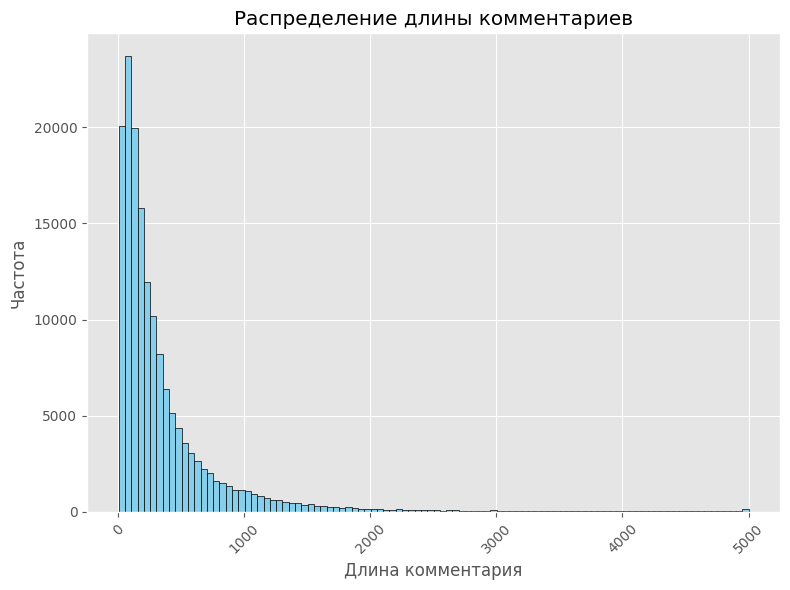

In [134]:
# Используем стиль ggplot для более привлекательного внешнего вида
plt.style.use('ggplot')

# Создание объекта Figure и осей
fig, ax = plt.subplots(figsize=(8, 6))

# Название графика и построение гистограммы
title = 'Распределение длины комментариев'
df['comment_length'].hist(ax=ax, bins=100, color='skyblue', edgecolor='black')

# Установка заголовка и меток осей
ax.set(title=title, xlabel='Длина комментария', ylabel='Частота')

# Добавление сетки для лучшей читаемости
ax.grid(True)

# Уменьшение перекрытия меток оси x
plt.xticks(rotation=45)

# Подгонка макета
plt.tight_layout()

# Отображение графика
plt.show()

## Посмотрим на распределение длины негативных и позитивных комментариев:

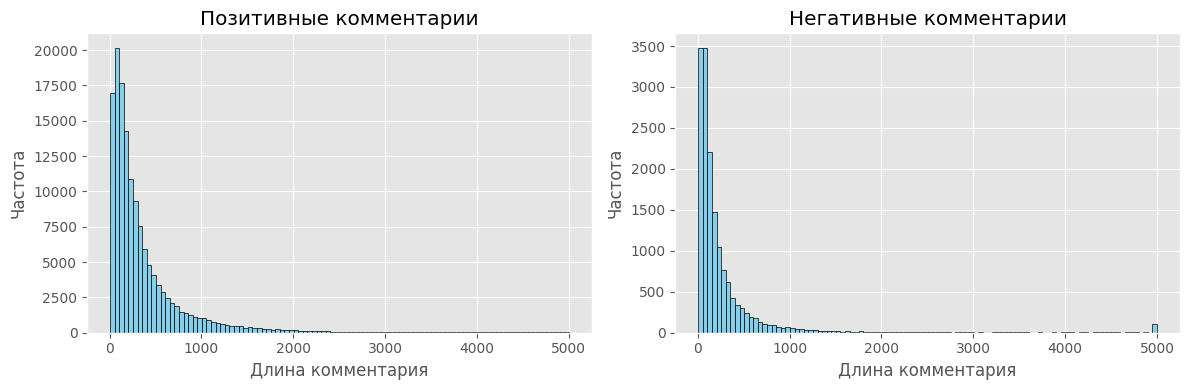

In [135]:
# Используем стиль ggplot для более привлекательного внешнего вида
plt.style.use('ggplot')

# Создание фигуры и осей
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Построение гистограмм для позитивных и токсичных комментариев
for i, title in enumerate(['Позитивные', 'Негативные']):
    df[df['toxic'] == i]['comment_length'].hist(ax=ax[i], bins=100, color='skyblue', edgecolor='black')
    ax[i].set(title=title + ' комментарии', xlabel='Длина комментария', ylabel='Частота')
    ax[i].grid(True)  # Добавление сетки

# Установка отступов между графиками
plt.tight_layout()

# Отображение гистограмм
plt.show()

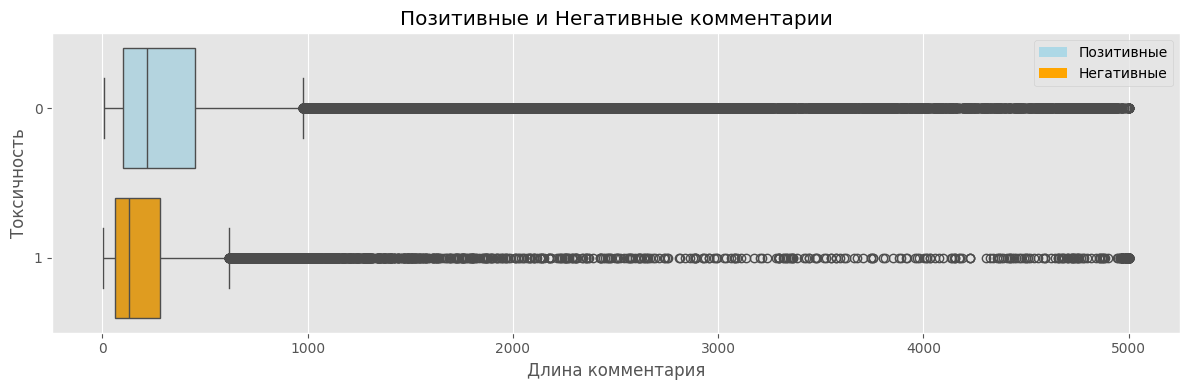

In [136]:
# Создание фигуры и осей
fig, ax = plt.subplots(figsize=(12, 4))

# Создание ящиковых графиков для позитивных и негативных комментариев
sns.boxplot(y='toxic', x='comment_length', orient='h', data=df, ax=ax, palette=['lightblue', 'orange'])

# Установка заголовка и меток осей
ax.set(title='Позитивные и Негативные комментарии', xlabel='Длина комментария', ylabel='Токсичность')

# Добавление легенды

legend_elements = [Patch(facecolor='lightblue', label='Позитивные'),
                   Patch(facecolor='orange', label='Негативные')]
ax.legend(handles=legend_elements)

# Подгонка макета
plt.tight_layout()

# Отображение графика
plt.show()

## Итог:

Отсутствуют серьезные различия в длине позитивных и негативных комментариев.

# TF-IDF (CPU)

Самый примитивны способ: использовать только слова встречаемые в исходном тексте. Обучение и предсказание происходит только на словаре, который сформировывается из слов комментариев.

Оцифровка слов происходит за счёт подсчёта их важности, величиной TF-IDF. То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

Примечание: бóльшая величина TF-IDF говорит об уникальности слова в тексте по отношению к корпусу. Чем чаще оно встречается в конкретном тексте и реже в остальных, тем выше значение TF-IDF.

In [160]:
# инициализация класса для лемматизации
WNLemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# функция определение части речи
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# функция лемматизации и очистки текста
def lemm_clear_text(text):
    word_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([WNLemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_list])
    lemm_text = re.sub(r"[a-zA-Z]+'?[a-zA-Z]+", '', lemm_text)
    lemm_text = lemm_text.split()
    lemm_clear_text =  ' '.join(lemm_text)
    return lemm_clear_text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [144]:
df['lemm_text'] = ""

for index, row in tqdm(df.iterrows(), total=len(df)):

    df.at[index, 'lemm_text'] = lemm_clear_text(row['text'])

100%|██████████| 159292/159292 [5:16:25<00:00,  8.39it/s]  


In [145]:
print('Исходный текст:', df.loc[1, 'text'])
print('Лемматизированный:', df.loc[1, 'lemm_text'])

Исходный текст: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Лемматизированный: Daww He match this background colour I m seemingly stuck with Thanks talk January UTC


In [146]:
df.to_csv('test_preprocessed.csv', index=False)

In [147]:
read_test_df = pd.read_csv('test_preprocessed.csv')



In [148]:
read_test_df

,text,toxic,comment_length,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,264,Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,112,Daww He match this background colour I m seemi...
2,"Hey man, I'm really not trying to edit war. It...",0,233,Hey man I m really not try to edit war It s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,622,More I ca nt make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,67,You sir be my hero Any chance you remember wha...
...,...,...,...,...
159287,""":::::And for the second time of asking, when ...",0,295,And for the second time of ask when your view ...
159288,You should be ashamed of yourself \n\nThat is ...,0,99,You should be ashamed of yourself That be a ho...
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,81,Spitzer Umm there no actual article for prosti...
159290,And it looks like it was actually you who put ...,0,116,And it look like it be actually you who put on...


In [150]:
read_test_df['lemm_text'][1]

'Daww He match this background colour I m seemingly stuck with Thanks talk January UTC'

In [152]:
anomaly_index = read_test_df[(read_test_df['lemm_text'].isna()) | (read_test_df['lemm_text']=='')].index
display(read_test_df.loc[anomaly_index])
read_test_df.drop(index=anomaly_index, inplace=True)
read_test_df.reset_index(drop=True, inplace=True)

,text,toxic,comment_length,lemm_text
4475,1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n...,0,64,NaN
6289,193.61.111.53 15:00,0,20,NaN
10193,"64.86.141.133""",0,14,NaN
17280,~ \n\n68.193.147.157,0,18,NaN
38743,"88.104.31.21""",0,13,NaN
52336,"14:53,",0,6,NaN
53679,92.24.199.233|92.24.199.233]],0,29,NaN
61644,"""\n\n 199.209.144.211 """,0,22,NaN
82541,"""\n '''''' 2010/2013 """,0,21,NaN
119018,"""""""",1,5,NaN


In [153]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# создание TF-IDF векторизатора с стоп словами (слова без смысловой нагрузки)
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [155]:
RANDOM_STATE = 42

In [158]:
# подготовка обучающей выборки
target = read_test_df['toxic']
features = read_test_df['lemm_text']

# выделение тренировочной выборки
X_train_tfidf, X_other, Y_train_tfidf, Y_other = train_test_split(features,
                                                                  target,
                                                                  stratify = target,
                                                                  train_size = 0.80,
                                                                  random_state = RANDOM_STATE)
# выделение валидационной и тестовой выборок
X_valid_tfidf, X_test_tfidf, Y_valid_tfidf, Y_test_tfidf = train_test_split(X_other,
                                                                            Y_other,
                                                                            stratify = Y_other,
                                                                            test_size = 0.50,
                                                                            random_state = RANDOM_STATE)

In [159]:
# "кодирование" текста
count_tf_idf.fit(X_train_tfidf)
X_train_tfidf = count_tf_idf.transform(X_train_tfidf)
X_valid_tfidf = count_tf_idf.transform(X_valid_tfidf)
X_test_tfidf  = count_tf_idf.transform(X_test_tfidf)

print('Количество признаков:', X_train_tfidf.shape[1])

Количество признаков: 169062
